# PV model
This script generates two ANN models for the battery: a dense MLP and a CNN

## Get packages and data

In [60]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy.ndimage import gaussian_filter1d
import keras_tuner as kt
os.sys.path.append('..')
from mtfunc import *

mpl.rcParams['figure.figsize'] = (20, 5)
mpl.rcParams['axes.grid'] = True

hour=60
day=24*hour

dt=hour

rdata0=pd.read_csv("/Users/adrianpaeckelripoll/nest_data_tot_4.csv")
rdata0.timestamp=pd.to_datetime(rdata0.timestamp,unit='ns')
rdata0.set_index('timestamp',inplace=True)
rdata0=rdata0.resample(f'{dt}T').mean().interpolate().dropna()
rdata=rdata0
rdata=rdata.loc[:,~rdata.columns.duplicated()]
rdata.rename(columns={'global_radiation_fc':'sun_fc'},inplace=True)

/Users/adrianpaeckelripoll/rbc-parameter-tuning/mtfunc   was appended to PYTHONPATH


##  Pre-process data

In [25]:
# Crop data
data=rdata[pd.Timestamp('2021-01-04'):pd.Timestamp('2022-01-01')].copy()
# Select PV generators to take into account
pv_signals=['power_pv_sfw_t100', 'power_pv_sfw_t101','power_pv_sfw_t102',
            'power_pv_sol_t100',
            'power_pv_meter_dfab','power_pv_move','power_pv_move_t100']

#Select experimental unit load to take into account, here: SFW,DFAB, VW, UMR, M2C, Move
loads=['power_sfw', 'power_dfab', 'power_sol','power_vw','power_umr','power_m2c','power_move']
data['power_pv']=-data[pv_signals].sum(axis=1)
#Signals to which we appply Gaussian filtering
signals=['power_pv', 'sun_fc', 
       'outside_temperature_fc','rh_outside_fc']
data[signals]=data[signals].apply(gaussian_filter1d,sigma=1,raw=True)

# Set time to start at Monday (for periodic time input)
print('Cos/sin week start on: ',data.index[0].strftime('%A'))
data=data.reset_index(drop=False)
data['time']=data.index
data['day_sin']=np.sin(2*np.pi*data.time*dt/day)
data['day_cos']=np.cos(2*np.pi*data.time*dt/day)
data['year_sin']=np.sin(2*np.pi*data.time*dt/day/365)
data['year_cos']=np.cos(2*np.pi*data.time*dt/day/365)
data=data.drop(columns=['time'])
data=data.reset_index(drop=True)
timestamp=data.pop('timestamp')
# Define inputs of the models
inputs=['sun_fc', 'outside_temperature_fc', 'rh_outside_fc',
       'solar_elevation', 'solar_azimuth']
#Define outputs of the model
outputs=['power_pv']
data=data[outputs+inputs]
#Select example day (for plots later)
N=121
example_df=data[N*day//dt:N*day//dt+4*day//dt]
#Create column labels dict
column_indices = {name: i for i, name in enumerate(data.columns)}
#Define training, validation and test set
days_tot = len(data)*dt//day
parts=1
train_days=days_tot*0.7/parts
val_days=days_tot*0.9/parts
test_days=days_tot/parts
train_df = data[0:int(train_days*day//dt)]
val_df = data[int(train_days*day//dt) : int(val_days*day//dt)]
test_df = data[int(val_days*day//dt):int(test_days*day//dt)]
num_features = data.shape[1]
#Calculate mean values of inputs (for normalization later)
train_mean=train_df.mean()[1:]
train_std=train_df.std()[1:]


Cos/sin week start on:  Monday


## Manage training loop

In [74]:
#Set prediction horizon
STEPS=24*hour//dt
#Helper class for managing time series data sets and training ANNs (based on keras tutorial)
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,example_df=None,label_columns=None,input_columns=None,stride=None):
        # Store the raw data.
        self.stride=stride
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.example_df=example_df

        # Work out the label column indices.
        self.label_columns = label_columns
        self.input_columns=input_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
    def plot(self, model=None, plot_col='power_pv',plot_input='sun_fc', max_subplots=5):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_input]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

        plt.xlabel('Time [h]')    
        
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        if self.input_columns is not None:
            inputs = tf.stack(
                [inputs[:, :, self.column_indices[name]] for name in self.input_columns],
                axis=-1)
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        print(labels)
        print(inputs)
        return inputs, labels

    def make_dataset(self, data,batch_size=32,shuffle=True):
        data = np.array(data, dtype=np.float32)
        if self.stride is not None: st=self.stride
        else: st=1
            
            
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=st,

          shuffle=shuffle,
          batch_size=batch_size,)

        ds = ds.map(self.split_window)
        return ds



    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
#       """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, 'example_df', None)
        if result is None:
            self._example = self.train
        else: 
            self._example=self.make_dataset(self.example_df,batch_size=3,shuffle=True)
        return next(iter(self._example))
     
MAX_EPOCHS = 10000

def compile_and_fit(model, window, patience=20):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(0.01),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,validation_data=window.val,
                      callbacks=[early_stopping])
    return history
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

## Tune hyperparameters of dense MLP 

In [6]:
w2 = WindowGenerator(input_width=STEPS, label_width=STEPS, shift=0,
                     label_columns=outputs,input_columns=inputs,stride=1)

def model_builder_dense(hp):
    hp_units_1 = hp.Int('units_1', min_value=len(inputs), max_value=10*len(inputs), step=1)
    hp_units_2 = hp.Int('units_2',min_value=len(inputs), max_value=10*len(inputs), step=1)
#     hp_lr=hp.Choice('learning_rate', [0.01,0.001,0.0001])
    dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Input((STEPS,len(inputs))),

    tf.keras.layers.Normalization(mean=train_mean.values, variance=np.square(train_std.values)),
#     tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=hp_units_1, activation='relu'),
    tf.keras.layers.Dense(units=hp_units_2, activation='relu'),
    tf.keras.layers.Dense(units=len(w2.label_columns),activation='relu'),
    ])

    dense.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(0.01),metrics=[tf.keras.metrics.Accuracy()])

    return dense

tuner = kt.Hyperband(model_builder_dense,
                     objective='loss',
                     max_epochs=300,
                     factor=3,
                     directory='tuner_dir_dense_PVpower_forecast_5',
                     project_name='dense_PV_model')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
tuner.search(w2.train, epochs=100,validation_data=w2.val, callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

INFO:tensorflow:Reloading Oracle from existing project tuner_dir_dense_PVpower_forecast_5/dense_PV_model/oracle.json


2022-03-07 05:26:32.256065: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Reloading Tuner from tuner_dir_dense_PVpower_forecast_5/dense_PV_model/tuner0.json
Tensor("stack:0", shape=(None, 24, 1), dtype=float32)
Tensor("stack_1:0", shape=(None, 24, 5), dtype=float32)
Tensor("stack:0", shape=(None, 24, 1), dtype=float32)
Tensor("stack_1:0", shape=(None, 24, 5), dtype=float32)
INFO:tensorflow:Oracle triggered exit


## Tune hyperparameters for CNN model

In [11]:
conv_width=3*hour//dt
w3 = WindowGenerator(input_width=STEPS+conv_width-1, label_width=STEPS, shift=0,
                     label_columns=outputs,input_columns=inputs,stride=STEPS//2)
def model_builder_conv(hp):
    hp_units_1 = hp.Int('filters', min_value=len(inputs), max_value=10*len(inputs), step=2)
    hp_units_2 = hp.Int('dense_units',min_value=len(inputs), max_value=10*len(inputs), step=2)
#     hp_lr=hp.Choice('learning_rate', [0.01,0.001,0.0001])

    conv_model = tf.keras.Sequential([

        tf.keras.layers.Input((w3.input_width,len(inputs))),
        tf.keras.layers.Normalization(mean=train_mean.values, variance=np.square(train_std.values)),

        tf.keras.layers.Conv1D(filters=hp_units_1,kernel_size=(conv_width,),activation='relu'),
    #     tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=hp_units_2, activation='relu'),
        tf.keras.layers.Dense(units=len(outputs), activation='relu'),
    #     tf.keras.layers.Reshape([STEPS, 1]),
    ])

    conv_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(0.001),metrics=[tf.keras.metrics.Accuracy()])

    return conv_model
tuner = kt.Hyperband(model_builder_conv,
                     objective='loss',
                     max_epochs=300,
                     factor=3,
                     directory='tuner_dir_conv_PVpower_forecast_4',
                     project_name='conv_PV_model')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)
tuner.search(w3.train, epochs=100,validation_data=w3.val, callbacks=[stop_early])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

INFO:tensorflow:Reloading Oracle from existing project tuner_dir_conv_PVpower_forecast_4/conv_PV_model/oracle.json
INFO:tensorflow:Reloading Tuner from tuner_dir_conv_PVpower_forecast_4/conv_PV_model/tuner0.json
Tensor("stack:0", shape=(None, 24, 1), dtype=float32)
Tensor("stack_1:0", shape=(None, 26, 5), dtype=float32)
Tensor("stack:0", shape=(None, 24, 1), dtype=float32)
Tensor("stack_1:0", shape=(None, 26, 5), dtype=float32)
INFO:tensorflow:Oracle triggered exit


## Create models

In [70]:
train_mean=train_df.mean()[1:]
train_std=train_df.std()[1:]
dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Input((STEPS,len(inputs))),
    tf.keras.layers.Normalization(mean=train_mean.values, variance=np.square(train_std.values)),
    tf.keras.layers.Dense(units=46, activation='relu'),
    tf.keras.layers.Dense(units=40, activation='relu'),
    tf.keras.layers.Dense(units=len(w2.label_columns),activation='relu'),

])
dense.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_8 (Normalizati (None, 24, 5)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 24, 46)            276       
_________________________________________________________________
dense_21 (Dense)             (None, 24, 40)            1880      
_________________________________________________________________
dense_22 (Dense)             (None, 24, 1)             41        
Total params: 2,197
Trainable params: 2,197
Non-trainable params: 0
_________________________________________________________________


In [73]:
conv_width=3*hour//dt
w3 = WindowGenerator(input_width=STEPS+conv_width-1, label_width=STEPS, shift=0,
                     label_columns=outputs,input_columns=inputs,stride=1)
conv_model = tf.keras.Sequential([
#     tf.keras.Input((24,len(w2.column_indices))),
    tf.keras.layers.Input((w3.input_width,len(inputs))),
    tf.keras.layers.Normalization(mean=train_mean.values, variance=np.square(train_std.values)),
#     (steps,ip)->(steps-conv_widt+1,ip)
    tf.keras.layers.Conv1D(filters=47,kernel_size=(conv_width,),activation='relu'),
#     tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=43, activation='relu'),
    tf.keras.layers.Dense(units=len(outputs), activation='relu'),
#     tf.keras.layers.Reshape([STEPS, 1]),
])
conv_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_10 (Normalizat (None, 26, 5)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 24, 47)            752       
_________________________________________________________________
dense_25 (Dense)             (None, 24, 43)            2064      
_________________________________________________________________
dense_26 (Dense)             (None, 24, 1)             44        
Total params: 2,860
Trainable params: 2,860
Non-trainable params: 0
_________________________________________________________________


## Compile and train models

Set patience to smaller values to avoid overfitting

In [76]:
history = compile_and_fit(dense, w2,500)
history = compile_and_fit(conv_model, w3,500)
IPython.display.clear_output()

Tensor("stack:0", shape=(None, 24, 1), dtype=float32)
Tensor("stack_1:0", shape=(None, 24, 5), dtype=float32)
Tensor("stack:0", shape=(None, 24, 1), dtype=float32)
Tensor("stack_1:0", shape=(None, 24, 5), dtype=float32)
Epoch 1/10000
190/190 [==============================] - 1s 3ms/step - loss: 12.8362 - mean_absolute_error: 1.8655 - val_loss: 42.1572 - val_mean_absolute_error: 3.1200
Epoch 2/10000
190/190 [==============================] - 1s 3ms/step - loss: 13.0818 - mean_absolute_error: 1.8990 - val_loss: 42.3423 - val_mean_absolute_error: 3.1242
Epoch 3/10000
190/190 [==============================] - 0s 3ms/step - loss: 12.8443 - mean_absolute_error: 1.8803 - val_loss: 42.8716 - val_mean_absolute_error: 3.2001
Epoch 4/10000
190/190 [==============================] - 0s 3ms/step - loss: 12.5251 - mean_absolute_error: 1.8474 - val_loss: 42.3537 - val_mean_absolute_error: 3.1486
Epoch 5/10000
190/190 [==============================] - 0s 2ms/step - loss: 12.9747 - mean_absolute_err

Epoch 48/10000
190/190 [==============================] - 0s 3ms/step - loss: 10.4309 - mean_absolute_error: 1.7153 - val_loss: 52.4879 - val_mean_absolute_error: 3.6440
Epoch 49/10000
190/190 [==============================] - 0s 2ms/step - loss: 10.5036 - mean_absolute_error: 1.7238 - val_loss: 59.0820 - val_mean_absolute_error: 3.8160
Epoch 50/10000
190/190 [==============================] - 0s 2ms/step - loss: 10.5783 - mean_absolute_error: 1.7337 - val_loss: 55.6931 - val_mean_absolute_error: 3.7059
Epoch 51/10000
190/190 [==============================] - 0s 2ms/step - loss: 10.6544 - mean_absolute_error: 1.7342 - val_loss: 62.8842 - val_mean_absolute_error: 3.9814
Epoch 52/10000
190/190 [==============================] - 0s 2ms/step - loss: 10.4360 - mean_absolute_error: 1.7203 - val_loss: 54.9398 - val_mean_absolute_error: 3.7006
Epoch 53/10000
190/190 [==============================] - 1s 3ms/step - loss: 10.6410 - mean_absolute_error: 1.7404 - val_loss: 56.1689 - val_mean_abs

190/190 [==============================] - 1s 3ms/step - loss: 9.4157 - mean_absolute_error: 1.6410 - val_loss: 65.4337 - val_mean_absolute_error: 4.0025
Epoch 145/10000
190/190 [==============================] - 0s 3ms/step - loss: 8.6890 - mean_absolute_error: 1.5739 - val_loss: 67.6880 - val_mean_absolute_error: 4.1266
Epoch 146/10000
190/190 [==============================] - 0s 2ms/step - loss: 8.8204 - mean_absolute_error: 1.5858 - val_loss: 67.1964 - val_mean_absolute_error: 4.1221
Epoch 147/10000
190/190 [==============================] - 0s 2ms/step - loss: 8.8016 - mean_absolute_error: 1.5902 - val_loss: 73.7492 - val_mean_absolute_error: 4.3198
Epoch 148/10000
190/190 [==============================] - 0s 2ms/step - loss: 9.2042 - mean_absolute_error: 1.6363 - val_loss: 67.4296 - val_mean_absolute_error: 4.1452
Epoch 149/10000
190/190 [==============================] - 0s 2ms/step - loss: 8.9598 - mean_absolute_error: 1.6043 - val_loss: 66.8754 - val_mean_absolute_error: 4.0

190/190 [==============================] - 0s 2ms/step - loss: 8.4247 - mean_absolute_error: 1.5588 - val_loss: 68.4107 - val_mean_absolute_error: 4.1633
Epoch 241/10000
190/190 [==============================] - 0s 2ms/step - loss: 8.0958 - mean_absolute_error: 1.5347 - val_loss: 69.5274 - val_mean_absolute_error: 4.1396
Epoch 242/10000
190/190 [==============================] - 0s 3ms/step - loss: 7.8556 - mean_absolute_error: 1.5035 - val_loss: 68.9327 - val_mean_absolute_error: 4.1413
Epoch 243/10000
190/190 [==============================] - 0s 2ms/step - loss: 8.1475 - mean_absolute_error: 1.5405 - val_loss: 69.4122 - val_mean_absolute_error: 4.1254
Epoch 244/10000
190/190 [==============================] - 0s 2ms/step - loss: 8.1909 - mean_absolute_error: 1.5365 - val_loss: 69.7401 - val_mean_absolute_error: 4.1767
Epoch 245/10000
190/190 [==============================] - 1s 3ms/step - loss: 8.2103 - mean_absolute_error: 1.5429 - val_loss: 64.0765 - val_mean_absolute_error: 4.0

190/190 [==============================] - 0s 2ms/step - loss: 7.5641 - mean_absolute_error: 1.4825 - val_loss: 71.6906 - val_mean_absolute_error: 4.1797
Epoch 337/10000
190/190 [==============================] - 0s 2ms/step - loss: 7.4725 - mean_absolute_error: 1.4780 - val_loss: 71.3968 - val_mean_absolute_error: 4.1878
Epoch 338/10000
190/190 [==============================] - 0s 2ms/step - loss: 7.5039 - mean_absolute_error: 1.4740 - val_loss: 66.0712 - val_mean_absolute_error: 4.0150
Epoch 339/10000
190/190 [==============================] - 0s 2ms/step - loss: 8.0352 - mean_absolute_error: 1.5402 - val_loss: 70.4378 - val_mean_absolute_error: 4.1892
Epoch 340/10000
190/190 [==============================] - 0s 2ms/step - loss: 7.6206 - mean_absolute_error: 1.4888 - val_loss: 69.9498 - val_mean_absolute_error: 4.1593
Epoch 341/10000
190/190 [==============================] - 0s 2ms/step - loss: 7.6686 - mean_absolute_error: 1.4939 - val_loss: 72.0493 - val_mean_absolute_error: 4.1

190/190 [==============================] - 0s 2ms/step - loss: 7.4202 - mean_absolute_error: 1.4717 - val_loss: 73.3504 - val_mean_absolute_error: 4.2170
Epoch 433/10000
190/190 [==============================] - 0s 2ms/step - loss: 7.3656 - mean_absolute_error: 1.4644 - val_loss: 73.4085 - val_mean_absolute_error: 4.2476
Epoch 434/10000
190/190 [==============================] - 0s 2ms/step - loss: 7.5207 - mean_absolute_error: 1.4847 - val_loss: 73.2249 - val_mean_absolute_error: 4.1910
Epoch 435/10000
190/190 [==============================] - 0s 2ms/step - loss: 7.3965 - mean_absolute_error: 1.4750 - val_loss: 71.4362 - val_mean_absolute_error: 4.1303
Epoch 436/10000
190/190 [==============================] - 0s 2ms/step - loss: 7.2919 - mean_absolute_error: 1.4641 - val_loss: 69.5404 - val_mean_absolute_error: 4.1155
Epoch 437/10000
190/190 [==============================] - 0s 2ms/step - loss: 7.5869 - mean_absolute_error: 1.4927 - val_loss: 74.9893 - val_mean_absolute_error: 4.2

190/190 [==============================] - 0s 2ms/step - loss: 6.6412 - mean_absolute_error: 1.3393 - val_loss: 68.2837 - val_mean_absolute_error: 3.8980
Epoch 27/10000
190/190 [==============================] - 1s 3ms/step - loss: 6.1105 - mean_absolute_error: 1.2835 - val_loss: 65.0580 - val_mean_absolute_error: 3.7542
Epoch 28/10000
190/190 [==============================] - 1s 3ms/step - loss: 6.3523 - mean_absolute_error: 1.3123 - val_loss: 76.2667 - val_mean_absolute_error: 3.9985
Epoch 29/10000
190/190 [==============================] - 1s 3ms/step - loss: 6.7055 - mean_absolute_error: 1.3577 - val_loss: 64.4498 - val_mean_absolute_error: 3.7449
Epoch 30/10000
190/190 [==============================] - 0s 2ms/step - loss: 6.4107 - mean_absolute_error: 1.3207 - val_loss: 57.5792 - val_mean_absolute_error: 3.5700
Epoch 31/10000
190/190 [==============================] - 1s 3ms/step - loss: 6.1442 - mean_absolute_error: 1.2954 - val_loss: 61.6140 - val_mean_absolute_error: 3.6374
E

190/190 [==============================] - 1s 3ms/step - loss: 4.4204 - mean_absolute_error: 1.1264 - val_loss: 65.4991 - val_mean_absolute_error: 3.7751
Epoch 123/10000
190/190 [==============================] - 1s 3ms/step - loss: 4.4397 - mean_absolute_error: 1.1301 - val_loss: 68.7216 - val_mean_absolute_error: 3.8991
Epoch 124/10000
190/190 [==============================] - 1s 3ms/step - loss: 4.6477 - mean_absolute_error: 1.1555 - val_loss: 67.2214 - val_mean_absolute_error: 3.8721
Epoch 125/10000
190/190 [==============================] - 1s 3ms/step - loss: 4.3916 - mean_absolute_error: 1.1263 - val_loss: 66.4790 - val_mean_absolute_error: 3.8424
Epoch 126/10000
190/190 [==============================] - 0s 3ms/step - loss: 4.3601 - mean_absolute_error: 1.1127 - val_loss: 69.6867 - val_mean_absolute_error: 3.9668
Epoch 127/10000
190/190 [==============================] - 1s 3ms/step - loss: 4.3515 - mean_absolute_error: 1.1210 - val_loss: 65.4882 - val_mean_absolute_error: 3.7

190/190 [==============================] - 0s 2ms/step - loss: 3.5345 - mean_absolute_error: 1.0362 - val_loss: 66.1228 - val_mean_absolute_error: 3.7347
Epoch 219/10000
190/190 [==============================] - 1s 3ms/step - loss: 3.3563 - mean_absolute_error: 1.0112 - val_loss: 66.4019 - val_mean_absolute_error: 3.7882
Epoch 220/10000
190/190 [==============================] - 1s 3ms/step - loss: 3.5999 - mean_absolute_error: 1.0409 - val_loss: 68.5838 - val_mean_absolute_error: 3.8810
Epoch 221/10000
190/190 [==============================] - 0s 2ms/step - loss: 3.4814 - mean_absolute_error: 1.0298 - val_loss: 64.6107 - val_mean_absolute_error: 3.7146
Epoch 222/10000
190/190 [==============================] - 1s 3ms/step - loss: 3.8466 - mean_absolute_error: 1.0777 - val_loss: 68.9975 - val_mean_absolute_error: 3.7837
Epoch 223/10000
190/190 [==============================] - 1s 3ms/step - loss: 3.3602 - mean_absolute_error: 1.0107 - val_loss: 72.6008 - val_mean_absolute_error: 3.9

190/190 [==============================] - 0s 2ms/step - loss: 2.8885 - mean_absolute_error: 0.9445 - val_loss: 63.1664 - val_mean_absolute_error: 3.6365
Epoch 315/10000
190/190 [==============================] - 0s 2ms/step - loss: 2.8833 - mean_absolute_error: 0.9461 - val_loss: 67.5590 - val_mean_absolute_error: 3.7472
Epoch 316/10000
190/190 [==============================] - 1s 3ms/step - loss: 3.3123 - mean_absolute_error: 1.0113 - val_loss: 64.8302 - val_mean_absolute_error: 3.6873
Epoch 317/10000
190/190 [==============================] - 0s 2ms/step - loss: 2.8804 - mean_absolute_error: 0.9461 - val_loss: 68.7314 - val_mean_absolute_error: 3.7668
Epoch 318/10000
190/190 [==============================] - 0s 2ms/step - loss: 3.2009 - mean_absolute_error: 1.0022 - val_loss: 77.0350 - val_mean_absolute_error: 3.9990
Epoch 319/10000
190/190 [==============================] - 0s 3ms/step - loss: 3.4231 - mean_absolute_error: 1.0354 - val_loss: 64.9931 - val_mean_absolute_error: 3.6

190/190 [==============================] - 0s 2ms/step - loss: 2.6667 - mean_absolute_error: 0.9133 - val_loss: 71.4633 - val_mean_absolute_error: 3.8224
Epoch 411/10000
190/190 [==============================] - 0s 2ms/step - loss: 2.7822 - mean_absolute_error: 0.9373 - val_loss: 67.4541 - val_mean_absolute_error: 3.7368
Epoch 412/10000
190/190 [==============================] - 0s 2ms/step - loss: 2.6902 - mean_absolute_error: 0.9221 - val_loss: 70.6186 - val_mean_absolute_error: 3.8153
Epoch 413/10000
190/190 [==============================] - 0s 2ms/step - loss: 2.6916 - mean_absolute_error: 0.9223 - val_loss: 63.1571 - val_mean_absolute_error: 3.6556
Epoch 414/10000
190/190 [==============================] - 0s 2ms/step - loss: 2.7501 - mean_absolute_error: 0.9314 - val_loss: 73.9370 - val_mean_absolute_error: 3.8788
Epoch 415/10000
190/190 [==============================] - 0s 2ms/step - loss: 2.8171 - mean_absolute_error: 0.9415 - val_loss: 72.1483 - val_mean_absolute_error: 3.8

190/190 [==============================] - 0s 2ms/step - loss: 2.3900 - mean_absolute_error: 0.8758 - val_loss: 81.0398 - val_mean_absolute_error: 4.0493
Epoch 507/10000
190/190 [==============================] - 0s 2ms/step - loss: 2.5915 - mean_absolute_error: 0.9134 - val_loss: 73.4912 - val_mean_absolute_error: 3.8793
Epoch 508/10000
190/190 [==============================] - 0s 2ms/step - loss: 2.3295 - mean_absolute_error: 0.8649 - val_loss: 73.0162 - val_mean_absolute_error: 3.8675
Epoch 509/10000
190/190 [==============================] - 0s 2ms/step - loss: 2.5164 - mean_absolute_error: 0.9000 - val_loss: 70.9177 - val_mean_absolute_error: 3.8364
Epoch 510/10000
190/190 [==============================] - 0s 2ms/step - loss: 2.2592 - mean_absolute_error: 0.8534 - val_loss: 87.4488 - val_mean_absolute_error: 4.2021
Epoch 511/10000
190/190 [==============================] - 0s 2ms/step - loss: 2.5002 - mean_absolute_error: 0.8937 - val_loss: 74.3290 - val_mean_absolute_error: 3.8

190/190 [==============================] - 0s 3ms/step - loss: 2.3917 - mean_absolute_error: 0.8830 - val_loss: 80.4307 - val_mean_absolute_error: 4.0222
Epoch 603/10000
190/190 [==============================] - 1s 3ms/step - loss: 2.3850 - mean_absolute_error: 0.8831 - val_loss: 73.5782 - val_mean_absolute_error: 3.8597
Epoch 604/10000
190/190 [==============================] - 1s 3ms/step - loss: 2.1675 - mean_absolute_error: 0.8375 - val_loss: 75.2701 - val_mean_absolute_error: 3.9026
Epoch 605/10000
190/190 [==============================] - 0s 3ms/step - loss: 2.1149 - mean_absolute_error: 0.8274 - val_loss: 74.1997 - val_mean_absolute_error: 3.8746
Epoch 606/10000
190/190 [==============================] - 1s 3ms/step - loss: 2.2970 - mean_absolute_error: 0.8694 - val_loss: 78.7416 - val_mean_absolute_error: 3.9792
Epoch 607/10000
190/190 [==============================] - 1s 3ms/step - loss: 2.6514 - mean_absolute_error: 0.9279 - val_loss: 78.1750 - val_mean_absolute_error: 3.9

## Evaluate models

Tensor("stack:0", shape=(None, 24, 1), dtype=float32)
Tensor("stack_1:0", shape=(None, 24, 5), dtype=float32)


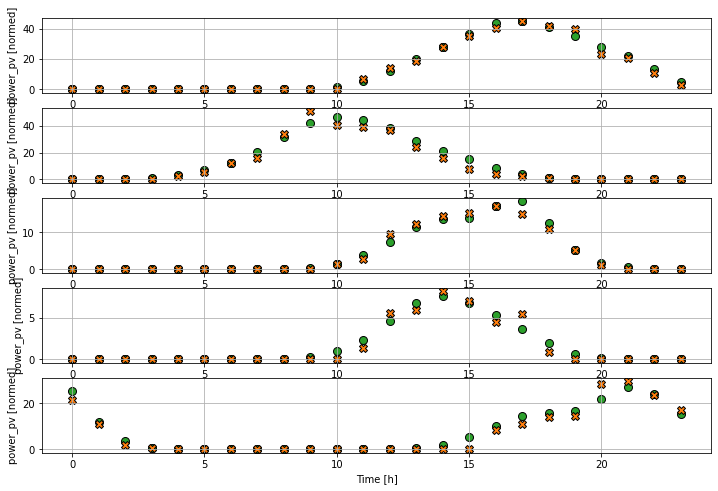

In [77]:
%matplotlib inline
w2.plot(dense)

In [ ]:
dense.save('../saved_models/s1PVpower_dense')

Tensor("stack:0", shape=(None, 24, 1), dtype=float32)
Tensor("stack_1:0", shape=(None, 26, 5), dtype=float32)


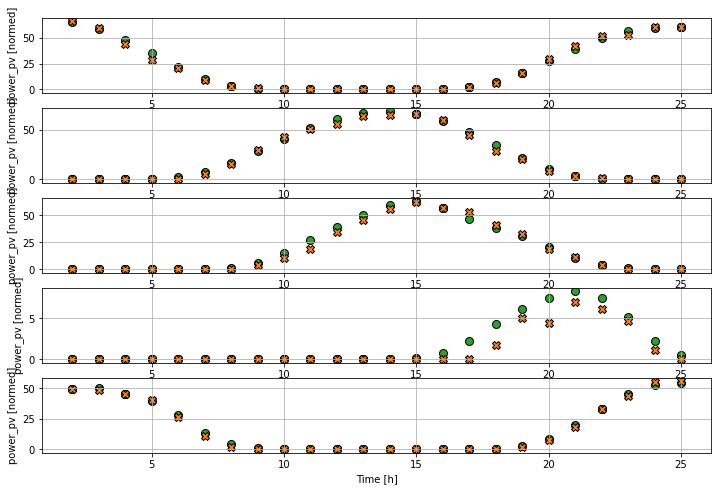

In [79]:
w3.plot(conv_model)

In [82]:
conv_model.save('../saved_models/s1PVpower_3conv')

INFO:tensorflow:Assets written to: ../saved_models/s1PVpower_3conv/assets


In [80]:
val_performance = {}
performance = {}
val_performance['dense'] = dense.evaluate(w2.val)
performance['dense'] = dense.evaluate(w2.test)
val_performance['conv'] = conv_model.evaluate(w3.val)
performance['conv'] = conv_model.evaluate(w3.test)



Tensor("stack:0", shape=(None, 24, 1), dtype=float32)
Tensor("stack_1:0", shape=(None, 24, 5), dtype=float32)
54/54 [==============================] - 0s 1ms/step - loss: 73.2436 - mean_absolute_error: 4.2185
Tensor("stack:0", shape=(None, 24, 1), dtype=float32)
Tensor("stack_1:0", shape=(None, 24, 5), dtype=float32)
27/27 [==============================] - 0s 1ms/step - loss: 12.3024 - mean_absolute_error: 1.5049
Tensor("stack:0", shape=(None, 24, 1), dtype=float32)
Tensor("stack_1:0", shape=(None, 26, 5), dtype=float32)
54/54 [==============================] - 0s 1ms/step - loss: 79.8787 - mean_absolute_error: 4.0088
Tensor("stack:0", shape=(None, 24, 1), dtype=float32)
Tensor("stack_1:0", shape=(None, 26, 5), dtype=float32)
27/27 [==============================] - 0s 1ms/step - loss: 13.5955 - mean_absolute_error: 1.4859


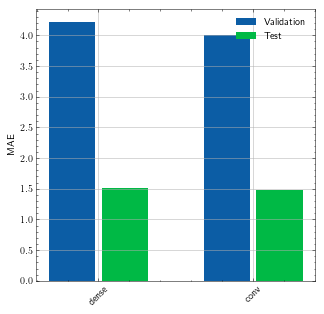

In [81]:
with plt.style.context('science'):
    plt.figure(figsize=(5,5))
    x = np.arange(len(performance))
    width = 0.3
    metric_name = 'mean_absolute_error'
    metric_index = dense.metrics_names.index(metric_name)
    val_mae = [v[metric_index] for v in val_performance.values()]
    test_mae = [v[metric_index] for v in performance.values()]

    plt.ylabel('MAE')
    plt.bar(x - 0.17, val_mae, width, label='Validation')
    plt.bar(x + 0.17, test_mae, width, label='Test')
    plt.xticks(ticks=x, labels=performance.keys(),
               rotation=45)
    _ = plt.legend()